## Import required libraries

In [1]:
from scipy.io.arff import loadarff
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, matthews_corrcoef

import warnings
warnings.filterwarnings("ignore")

## Load dataset

In [2]:
raw_data = loadarff("./dataset/PC3.arff")
data = pd.DataFrame(raw_data[0])
data['Defective'] = data['Defective'].apply(lambda x: 1 if x.decode() == 'Y' else 0)
data.head()

,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DECISION_DENSITY,...,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL,Defective
0,16.0,13.0,1.0,6.0,11.0,20.0,7.0,0.24,8.0,2.5,...,17.0,0.12,68.0,81.0,31.0,21.0,57.0,42.50,29.0,0
1,2.0,7.0,0.0,0.0,7.0,10.0,4.0,0.29,4.0,2.5,...,9.0,0.17,9.0,22.0,5.0,8.0,24.0,33.33,14.0,1
2,1.0,13.0,5.0,0.0,0.0,22.0,7.0,0.37,10.0,2.2,...,23.0,0.33,38.0,53.0,19.0,19.0,21.0,0.00,19.0,0
3,8.0,3.0,1.0,0.0,1.0,4.0,2.0,0.14,2.0,2.0,...,6.0,0.08,32.0,38.0,19.0,13.0,24.0,6.67,14.0,0
4,1.0,5.0,2.0,1.0,1.0,6.0,3.0,0.15,2.0,3.0,...,9.0,0.13,27.0,33.0,19.0,14.0,23.0,9.52,20.0,0


In [3]:
def MCC(yt,yp):
    tn, fp, fn, tp = confusion_matrix(yt, yp).ravel()
    #print(confusion_matrix(yt, yp))
    den=(tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
    if den==0:
        den=1
    return (tp*tn-fp*fn)/den**0.5

## Model Training and Testing without Feature Selection

In [4]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

### K-Nearest Neighbour

In [5]:
knn = KNeighborsClassifier(n_neighbors = 89)
knn.fit(X_train, y_train)
print(f"Score: {knn.score(X_test, y_test)}")
y_pred=knn.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.8734567901234568
MCC: 0.0


### Naive Bayes

In [6]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(f"Score: {gnb.score(X_test, y_test)}")
y_pred=gnb.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.6141975308641975
MCC: 0.24734100315741628


### Decision Tree

In [7]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
print(f"Score: {dtc.score(X_test, y_test)}")
y_pred=dtc.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.8425925925925926
MCC: 0.24944996805736358


### Random Forest

In [8]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print(f"Score: {rfc.score(X_test, y_test)}")
y_pred=rfc.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.8672839506172839
MCC: 0.14678570117000314


### AdaBoost

In [9]:
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
print(f"Score: {abc.score(X_test, y_test)}")
y_pred=abc.predict(X_test)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.8672839506172839
MCC: 0.23191434780659123


## Correlation Matrix of Dataset

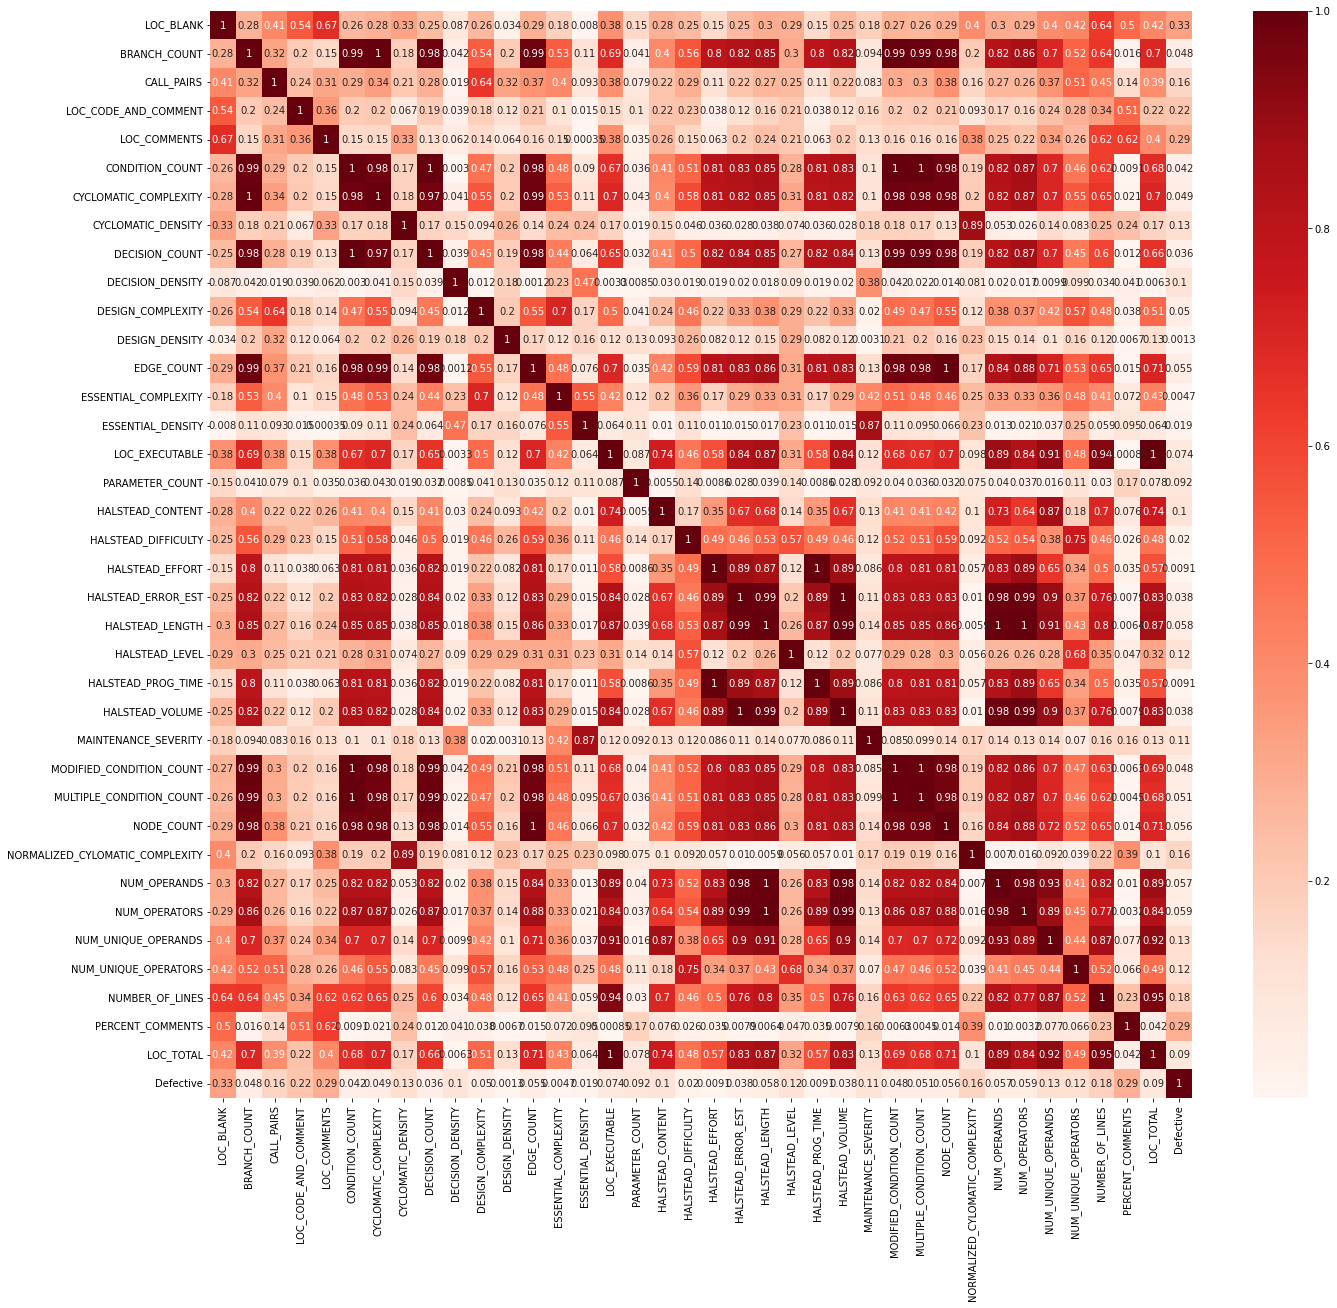

In [10]:
correlation_matrix = data.corr().abs()
plt.figure(figsize = (22, 20))
sns.heatmap(correlation_matrix, annot = True, cmap = plt.cm.Reds)
plt.show()

## Model training and testing with Hybrid Feature Selection

In [11]:
upper_triangular_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k = 1).astype(bool))
features_to_drop = [column for column in upper_triangular_matrix.columns if any(upper_triangular_matrix[column] > 0.95)]
print("Features to drop: ", features_to_drop)
data = data.drop(features_to_drop, axis = 1)
data.head()

Features to drop:  ['CONDITION_COUNT', 'CYCLOMATIC_COMPLEXITY', 'DECISION_COUNT', 'EDGE_COUNT', 'HALSTEAD_LENGTH', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME', 'MODIFIED_CONDITION_COUNT', 'MULTIPLE_CONDITION_COUNT', 'NODE_COUNT', 'NUM_OPERANDS', 'NUM_OPERATORS', 'LOC_TOTAL']


,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CYCLOMATIC_DENSITY,DECISION_DENSITY,DESIGN_COMPLEXITY,DESIGN_DENSITY,ESSENTIAL_COMPLEXITY,...,HALSTEAD_EFFORT,HALSTEAD_ERROR_EST,HALSTEAD_LEVEL,MAINTENANCE_SEVERITY,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,Defective
0,16.0,13.0,1.0,6.0,11.0,0.24,2.5,3.0,0.43,6.0,...,19562.81,0.28,0.04,0.86,0.12,31.0,21.0,57.0,42.50,0
1,2.0,7.0,0.0,0.0,7.0,0.29,2.5,1.0,0.25,4.0,...,825.94,0.04,0.14,1.00,0.17,5.0,8.0,24.0,33.33,1
2,1.0,13.0,5.0,0.0,0.0,0.37,2.2,4.0,0.57,7.0,...,9073.67,0.16,0.05,1.00,0.33,19.0,19.0,21.0,0.00,0
3,8.0,3.0,1.0,0.0,1.0,0.14,2.0,2.0,1.00,1.0,...,3831.58,0.12,0.09,0.50,0.08,19.0,13.0,24.0,6.67,0
4,1.0,5.0,2.0,1.0,1.0,0.15,3.0,2.0,0.67,3.0,...,3010.71,0.10,0.10,1.00,0.13,19.0,14.0,23.0,9.52,0


In [12]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

### K-Nearest Neighbour

In [14]:
knn = KNeighborsClassifier(n_neighbors=89)
sfs = SequentialFeatureSelector(knn)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
knn.fit(X_train_sfs, y_train)
print(f"Score: {knn.score(X_test_sfs, y_test)}")
y_pred=knn.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.8734567901234568
MCC: 0.0


Selected features for KNN

In [15]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_BLANK', 'BRANCH_COUNT', 'CALL_PAIRS', 'LOC_CODE_AND_COMMENT',
       'LOC_COMMENTS', 'CYCLOMATIC_DENSITY', 'DECISION_DENSITY',
       'DESIGN_COMPLEXITY', 'DESIGN_DENSITY', 'ESSENTIAL_COMPLEXITY',
       'ESSENTIAL_DENSITY', 'LOC_EXECUTABLE'],
      dtype='object')

### Naive Bayes

In [16]:
gnb = GaussianNB()
sfs = SequentialFeatureSelector(gnb)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
gnb.fit(X_train_sfs, y_train)
print(f"Score: {gnb.score(X_test_sfs, y_test)}")
y_pred=gnb.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.8271604938271605
MCC: 0.2341948473631997


Selected Features for Naive Bayes

In [17]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_BLANK', 'BRANCH_COUNT', 'CALL_PAIRS', 'CYCLOMATIC_DENSITY',
       'DECISION_DENSITY', 'DESIGN_COMPLEXITY', 'DESIGN_DENSITY',
       'ESSENTIAL_COMPLEXITY', 'ESSENTIAL_DENSITY', 'PARAMETER_COUNT',
       'MAINTENANCE_SEVERITY', 'NORMALIZED_CYLOMATIC_COMPLEXITY'],
      dtype='object')

### Decision Tree

In [18]:
dtc = DecisionTreeClassifier()
sfs = SequentialFeatureSelector(dtc)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
dtc.fit(X_train_sfs, y_train)
print(f"Score: {dtc.score(X_test_sfs, y_test)}")
y_pred=dtc.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.8055555555555556
MCC: 0.1643529914410269


Selected features for Decision Tree

In [19]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_BLANK', 'CALL_PAIRS', 'DECISION_DENSITY', 'DESIGN_DENSITY',
       'ESSENTIAL_COMPLEXITY', 'ESSENTIAL_DENSITY', 'LOC_EXECUTABLE',
       'HALSTEAD_ERROR_EST', 'HALSTEAD_LEVEL', 'MAINTENANCE_SEVERITY',
       'NORMALIZED_CYLOMATIC_COMPLEXITY', 'NUMBER_OF_LINES'],
      dtype='object')

### Random Forest

In [20]:
rfc = RandomForestClassifier()
sfs = SequentialFeatureSelector(rfc)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
rfc.fit(X_train_sfs, y_train)
print(f"Score: {rfc.score(X_test_sfs, y_test)}")
y_pred=rfc.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.8827160493827161
MCC: 0.2627037983619122


Selected features for Random Forest

In [21]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_CODE_AND_COMMENT', 'CYCLOMATIC_DENSITY', 'DESIGN_COMPLEXITY',
       'DESIGN_DENSITY', 'ESSENTIAL_COMPLEXITY', 'ESSENTIAL_DENSITY',
       'PARAMETER_COUNT', 'HALSTEAD_EFFORT', 'HALSTEAD_LEVEL',
       'NORMALIZED_CYLOMATIC_COMPLEXITY', 'NUM_UNIQUE_OPERANDS',
       'PERCENT_COMMENTS'],
      dtype='object')

### AdaBoost

In [22]:
abc = AdaBoostClassifier()
sfs = SequentialFeatureSelector(abc)
X_train_sfs = sfs.fit_transform(X_train, y_train)
X_test_sfs = sfs.transform(X_test)
abc.fit(X_train_sfs, y_train)
print(f"Score: {abc.score(X_test_sfs, y_test)}")
y_pred=abc.predict(X_test_sfs)
print(f"MCC: {matthews_corrcoef(y_test,y_pred)}")

Score: 0.8549382716049383
MCC: 0.19248050374632703


Selected features for AdaBoost Classifier

In [23]:
selected_features_index = sfs.get_support(True)
data.columns[selected_features_index]

Index(['LOC_BLANK', 'CALL_PAIRS', 'LOC_COMMENTS', 'DESIGN_DENSITY',
       'ESSENTIAL_COMPLEXITY', 'PARAMETER_COUNT', 'HALSTEAD_DIFFICULTY',
       'HALSTEAD_ERROR_EST', 'HALSTEAD_LEVEL', 'MAINTENANCE_SEVERITY',
       'NUM_UNIQUE_OPERATORS', 'NUMBER_OF_LINES'],
      dtype='object')